# Feature Selection and Engineering

## Start Spark Session

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Bosch Project").getOrCreate()

In [3]:
spark

In [7]:
import time
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Through previous EDA step, we notice that:
* For ***numerical*** features, the number of features is 970.
* For ***categorical*** features, the number of features is 2141.
* For ***date*** features, the number of features is 1157.
* A lot of features in date dataset are duplicate. Unique columns are: 
`['L3_S37_D3949', 'L3_S30_D3541', 'L3_S29_D3428', 'L3_S34_D3877', 'L3_S33_D3870', 'L0_S0_D3', 'L0_S1_D30', 'L0_S8_D145', 'L3_S36_D3919', 'L3_S35_D3910', 'L0_S5_D115', 'L0_S3_D70', 'L0_S6_D120', 'L0_S7_D143', 'L0_S2_D54', 'L0_S4_D106', 'L0_S12_D333', 'L0_S20_D465', 'L0_S13_D355', 'L0_S10_D266', 'L0_S11_D284', 'L0_S9_D192', 'L2_S26_D3084', 'L1_S24_D1828', 'L0_S19_D457', 'L0_S17_D432', 'L0_S14_D380', 'L0_S15_D401', 'L0_S16_D428', 'L2_S27_D3156', 'L0_S18_D447', 'L0_S21_D469', 'L0_S23_D629', 'L0_S22_D608', 'L3_S41_D4021', 'L3_S40_D3981', 'L3_S45_D4129', 'L3_S48_D4203', 'L3_S47_D4155', 'L3_S39_D3974', 'L3_S51_D4255', 'L1_S25_D1887', 'L3_S31_D3848', 'L3_S43_D4097', 'L3_S49_D4208', 'L3_S50_D4254', 'L3_S44_D4122', 'L3_S38_D3953', 'L3_S32_D3852', 'L2_S28_D3234', 'L3_S46_D4135', 'L3_S42_D4057']`
* Average failure rate is **0.58%** which implies that our target is highly skewed.

# Method 1: Feature Engineering

## Numerical Feature Engineering

First, we are going to handle our numeric features. Considering that we have thousands of columns with various kinds of features, we need to find a way to aggregate valueable information hidden below these features.

In [4]:
num = spark.read\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .format('csv')\
  .load('s3://jiaruxu233/train_numeric.csv')

"cat = spark.read  .option('header', 'true')  .option('inferSchema', 'true')  .format('csv')  .load('train_categorical.csv')\n\ndate = spark.read  .option('header', 'true')  .option('inferSchema', 'true')  .format('csv')  .load('train_date.csv')"

For convenience,we are going to explore the first 10000 rows first.

In [8]:
num_pd = pd.read_csv('s3://jiaruxu233/train_numeric.csv',nrows = 10000)

In [8]:
features = num_pd.drop(['Response', 'Id'], axis=1).columns.values

In [10]:
def organize(features):
    line_features = {}
    station_features = {}
    lines = set([f.split('_')[0] for f in features])
    stations = set([f.split('_')[1] for f in features])
    
    for l in lines:
        line_features[l] = [f for f in features if l+'_' in f]
        
    for s in stations:
        station_features[s] = [f for f in features if s+'_' in f]
        
            
    return line_features, station_features

line_features, station_features = organize(features)

# Eg. Feature for station 32 will be feature 3850
print("Features in Station 32: {}".format( station_features['S32'] ))

Features in Station 32: ['L3_S32_F3850']


In [11]:
station_error = []
for s in station_features:
    cols = ['Id', 'Response']
    cols.extend(station_features[s])
    df = num_pd_t.dropna(subset=station_features[s], how='all')
    error_rate = df[df.Response == 1].size / float(df[df.Response == 0].size)
    station_error.append([df.shape[1]-2, df.shape[0], error_rate]) 
    
station_data = pd.DataFrame(station_error, 
                         columns=['Features', 'Samples', 'Error_Rate'], 
                         index=station_features).sort_index()

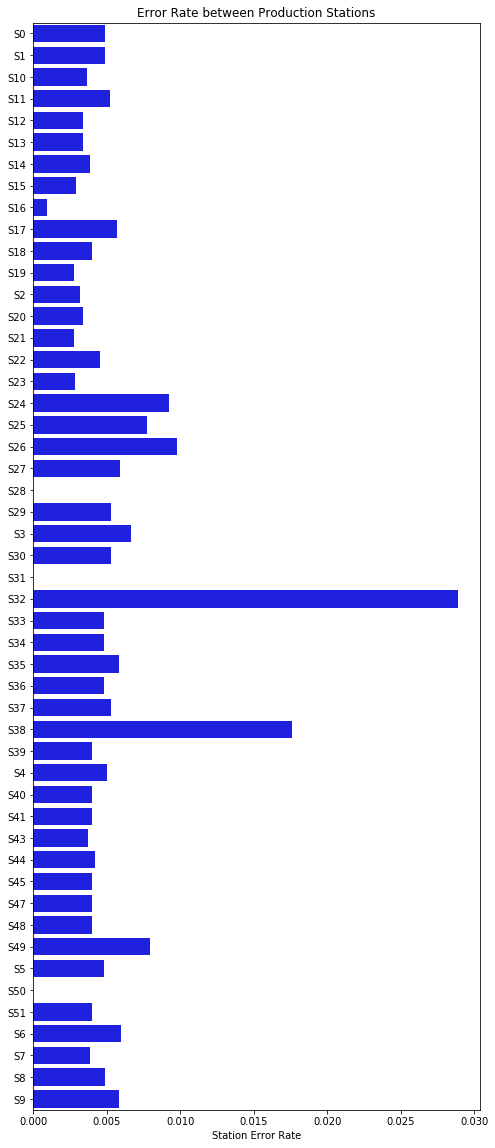

In [12]:
plt.figure(figsize=(8, 20))
sns.barplot(x='Error_Rate', y=station_data.index.values, data=station_data, color="blue")
plt.title('Error Rate between Production Stations')
plt.xlabel('Station Error Rate')
plt.show()

From plot above, we notice that station 32 and 38 have distinctively high failure rate with station 24,26 and 49,6 following.

In [13]:
data = num_pd

def make_features(df):
    new_features = pd.DataFrame({})
    for s in station_features.keys():
        station_data = df[station_features[s]]
        col = s+'_max'
        new_features[col] = station_data.max(axis=1).fillna(-1.)
        col = s+'_min'
        new_features[col] = station_data.min(axis=1).fillna(-1.)
    return new_features

data = make_features(data)

In [14]:
Id_ = pd.DataFrame(num_pd['Id'])

In [15]:
new_df_numerical = pd.concat([Id_,data],axis=1)

In [16]:
new_df_numerical.head()

,Id,S2_max,S2_min,S19_max,S19_min,S17_max,S17_min,S1_max,S1_min,S34_max,...,S20_max,S20_min,S31_max,S31_min,S36_max,S36_min,S51_max,S51_min,S9_max,S9_min
0,4,0.010,-0.223,-1.0,-1.0,-1.0,-1.0,0.167,-0.271,0.0,...,-1.0,-1.000,0.002,-0.049,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
1,6,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,0.0,...,0.0,-0.197,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
2,7,0.011,-0.223,-1.0,-1.0,-1.0,-1.0,0.057,-0.079,0.0,...,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
3,9,0.120,-0.231,-1.0,-1.0,-1.0,-1.0,0.147,-0.007,0.0,...,-1.0,-1.000,-1.000,-1.000,0.000,-0.192,-1.0,-1.0,-1.0,-1.0
4,11,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-0.012,-0.046,0.0,...,-1.0,-1.000,-1.000,-1.000,0.083,-0.092,-1.0,-1.0,-1.0,-1.0


Next, we output our modified numeric features to a s3 bucket.

In [18]:
new_df_numerical.to_csv('s3://jiaruxu233/new_train_numerical.csv')

## Categorical Feature Engineering

Through previous exploration, we notice that categorical features are the most missing one among our three types of features. Besides, many features only have one unique value in whole column which do not provide much help to our model. Therefore, we decide to pick features with most variety.

In [66]:
cat = spark.read\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .format('csv')\
  .load('s3://jiaruxu233/train_categorical.csv')

In [67]:
dfcat = cat.createOrReplaceTempView("dfcat")

In [1]:
# spark.sql('SELECT * FROM dfcat LIMIT 5').show()

In [73]:
cat_pd = pd.DataFrame(cat.head(10000),columns=cat.columns)

In [82]:
for k, v in cat_pd.nunique().to_dict().items():
    if v > 3:
        print('{}={}'.format(k,v))

Id=10000
L1_S24_F1114=4
L1_S24_F1137=4
L1_S24_F1140=4
L1_S24_F1510=5
L1_S24_F1525=5
L1_S24_F1530=5
L1_S25_F1852=5
L1_S25_F2779=5
L3_S32_F3854=14


In [83]:
cat_columns = ['L1_S24_F1114','L1_S24_F1137','L1_S24_F1140','L1_S24_F1510','L1_S24_F1525','L1_S24_F1530','L1_S25_F1852','L1_S25_F2779','L3_S32_F3854']

In [84]:
cat_df = pd.read_csv('s3://jiaruxu233/train_categorical.csv',usecols=cat_columns) 

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (576,588,590,807,811,815,984,1429,1987) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [85]:
cat_df.to_csv('s3://jiaruxu233/new_train_cat.csv')

## Date Feature Engineering

For Date features, we pick up those unique columns as we previously discovered in Step 1.

In [61]:
date_columns = ['L3_S37_D3949', 'L3_S30_D3541', 'L3_S29_D3428', 'L3_S34_D3877', 'L3_S33_D3870', 'L0_S0_D3', 'L0_S1_D30', 'L0_S8_D145', 'L3_S36_D3919', 'L3_S35_D3910', 'L0_S5_D115', 'L0_S3_D70', 'L0_S6_D120', 'L0_S7_D143', 'L0_S2_D54', 'L0_S4_D106', 'L0_S12_D333', 'L0_S20_D465', 'L0_S13_D355', 'L0_S10_D266', 'L0_S11_D284', 'L0_S9_D192', 'L2_S26_D3084', 'L1_S24_D1828', 'L0_S19_D457', 'L0_S17_D432', 'L0_S14_D380', 'L0_S15_D401', 'L0_S16_D428', 'L2_S27_D3156', 'L0_S18_D447', 'L0_S21_D469', 'L0_S23_D629', 'L0_S22_D608', 'L3_S41_D4021', 'L3_S40_D3981', 'L3_S45_D4129', 'L3_S48_D4203', 'L3_S47_D4155', 'L3_S39_D3974', 'L3_S51_D4255', 'L1_S25_D1887', 'L3_S31_D3848', 'L3_S43_D4097', 'L3_S49_D4208', 'L3_S50_D4254', 'L3_S44_D4122', 'L3_S38_D3953', 'L3_S32_D3852', 'L2_S28_D3234', 'L3_S46_D4135', 'L3_S42_D4057']

In [63]:
date_df = pd.read_csv('s3://jiaruxu233/train_date.csv',usecols=date_columns) 

In [58]:
# date_pd = pd.DataFrame(new_date.head(10000),columns=new_date.columns)

# date = spark.read\
#   .option('header', 'true')\
#   .option('inferSchema', 'true')\
#   .format('csv')\
#   .load('train_date.csv')

In [65]:
date_df.to_csv('s3://jiaruxu233/new_train_date.csv')

In [86]:
spark.stop()

# Method 2: Select From Model

## Dealing with imbalanced data 

In [10]:
# Load train_numeric
train_num =spark.read.csv('s3://jiaruxu233/train_numeric.csv', header = True, inferSchema = True)

In [11]:
# Load train_categorical
train_cat = spark.read.csv('s3://jiaruxu233/train_categorical.csv', header = True, inferSchema = True)

In [12]:
# Load train_date
train_date = spark.read.csv('s3://jiaruxu233/train_date.csv', header = True, inferSchema = True)

In [13]:
### Subset train_date set
date_columns = ['Id','L3_S37_D3949', 'L3_S30_D3541', 'L3_S29_D3428', 'L3_S34_D3877', 'L3_S33_D3870', 'L0_S0_D3', 'L0_S1_D30', 'L0_S8_D145', 'L3_S36_D3919', 'L3_S35_D3910', 'L0_S5_D115', 'L0_S3_D70', 'L0_S6_D120', 'L0_S7_D143', 'L0_S2_D54', 'L0_S4_D106', 'L0_S12_D333', 'L0_S20_D465', 'L0_S13_D355', 'L0_S10_D266', 'L0_S11_D284', 'L0_S9_D192', 'L2_S26_D3084', 'L1_S24_D1828', 'L0_S19_D457', 'L0_S17_D432', 'L0_S14_D380', 'L0_S15_D401', 'L0_S16_D428', 'L2_S27_D3156', 'L0_S18_D447', 'L0_S21_D469', 'L0_S23_D629', 'L0_S22_D608', 'L3_S41_D4021', 'L3_S40_D3981', 'L3_S45_D4129', 'L3_S48_D4203', 'L3_S47_D4155', 'L3_S39_D3974', 'L3_S51_D4255', 'L1_S25_D1887', 'L3_S31_D3848', 'L3_S43_D4097', 'L3_S49_D4208', 'L3_S50_D4254', 'L3_S44_D4122', 'L3_S38_D3953', 'L3_S32_D3852', 'L2_S28_D3234', 'L3_S46_D4135', 'L3_S42_D4057']
new_date = train_date.select(date_columns)

In [14]:
### Because we have to treat different type of data respectively.
cat_withlabel = train_num.select("Id","Response").join(train_cat, "Id")
date_withlabel = train_num.select("Id","Response").join(new_date, "Id")

In [15]:
a = train_num.filter(train_num.Response == 1)
b = cat_withlabel.filter(cat_withlabel.Response == 1)
c = date_withlabel.filter(date_withlabel.Response == 1)

In [16]:
a.count() # Calculate the number of all the broken parts

6879

In [17]:
# Randomly extract same amount of data from the rest of the set
a1 = train_num.filter(train_num.Response == 0).sample(0.03, seed = 1234)

In [18]:
# Exact other features for those records being randomly chose in a1
b1 = a1.select('Id').join(cat_withlabel, "Id")
c1 = a1.select('Id').join(date_withlabel, "Id")

In [19]:
num = a1.count()

Now we have 6 dataset in total, 3 for each type of features for each class of label `Response`, and we make each class has the approximately same size.

### Feature selection using XGboost

In [22]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier

In [23]:
a_pd = pd.DataFrame(a.head(6879), columns = a.columns)
b_pd = pd.DataFrame(b.head(6879), columns = b.columns)
c_pd = pd.DataFrame(c.head(6879), columns = c.columns)

In [24]:
a1_pd = pd.DataFrame(a1.head(num), columns = a1.columns)
b1_pd = pd.DataFrame(b1.head(num), columns = b1.columns)
c1_pd = pd.DataFrame(c1.head(num), columns = c1.columns)

In [25]:
# encode string input values as float
b_pd_encoded = pd.get_dummies(b_pd,dtype=float)
b1_pd_encoded = pd.get_dummies(b1_pd,dtype=float)

In [26]:
# Join the datasets on Id
r0 = a_pd.merge(b_pd_encoded,on=['Id','Response']).merge(c_pd,on=['Id','Response']).dropna(how='all', axis=1)
r1 = a1_pd.merge(b1_pd_encoded,on=['Id','Response']).merge(c1_pd, on=['Id','Response']).dropna(how='all', axis=1)

In [27]:
# Concat the dataset and shuffling
pre = pd.concat([r0, r1], sort = False).sample(frac=1).reset_index(drop=True)

In [28]:
X = pre.drop(['Response', 'Id'],axis=1)
y = pre['Response']

In [29]:
model = XGBClassifier(n_estimators = 3000, max_depth = 8, colsample_bytree = 0.2, colsample_bylevel=0.5, colsample_bynode=0.5)
model.fit(X,  y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=0.5, colsample_bytree=0.2, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=3000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [30]:
important_features = model.get_booster().get_score(importance_type='gain')

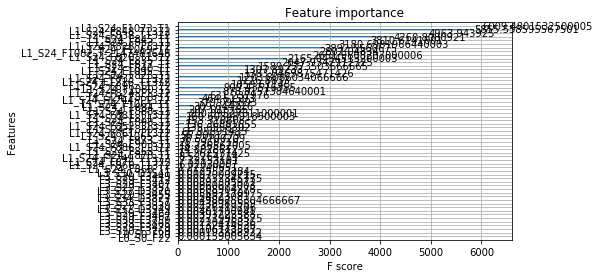

In [31]:
from xgboost import plot_importance
# plot feature importance
plot_importance(model,
                importance_type='gain'
                #max_num_features=30
               )

In [32]:
for key, value in sorted(important_features.items(), key=lambda item: item[1],reverse=True):
    print("%s: %s" % (key, value))

L1_S24_F1073_T1: 6009.4801532500005
L1_S24_F848_T1372: 5855.558595567501
L1_S24_F838_T1372: 4963.943925
L1_S24_F845_T1: 4260.8080921
L1_S24_F853_T1: 3810.6141601
L1_S24_F828_T1372: 3180.6981966440003
L1_S24_F1069_T1: 2892.5560675
L1_S24_F1082_T-2147483648: 2802.04834
L1_S24_F820_T1372: 2651.9608207000006
L1_S24_F835_T1: 2165.0434513200003
L1_S24_F817_T1: 2047.9342912325
L1_S24_F840_T1: 1589.2373503666665
L1_S24_F1095_T1: 1307.89233
L1_S24_F825_T1: 1303.0469875471426
L1_S24_F833_T1372: 1203.8086034066666
L1_S24_F1216_T1372: 1176.8833
L1_S24_F896_T1372: 1059.61145
L1_S24_F1080_T1: 909.43516355
L1_S24_F824_T1372: 878.8151384640001
L1_S24_F858_T1: 631.237976
L1_S24_F1244_T1372: 464.51593
L1_S24_F1061_T1: 379.096893
L1_S24_F1084_T1: 309.644226
L1_S24_F888_T1: 207.016785
L1_S24_F881_T1372: 200.09527611000001
L1_S24_F821_T1: 160.60348918500003
L1_S24_F898_T1: 153.310608
L1_S24_F852_T1372: 136.36881655
L1_S24_F830_T1: 135.6558302
L1_S24_F861_T1372: 66.95891435
L1_S24_F1065_T1: 56.9061279
L1_S2

In [33]:
imp = list(important_features.keys())

In [36]:
import re
feature = []
pattern = re.compile("L\d_S\d+_F\d+")
for x in imp:
    i = pattern.findall(x)
    feature.append(*i)

In [37]:
c_feature = ['L1_S24_F1078',
 'L1_S24_F833',
 'L0_S2_F63',
 'L0_S2_F67',
 'L1_S24_F866',
 'L1_S24_F838',
 'L1_S24_F849',
 'L1_S24_F824',
 'L1_S24_F873',
 'L1_S24_F817',
 'L1_S24_F825',
 'L1_S24_F871',
 'L1_S24_F1095',
 'L1_S24_F845',
 'L1_S24_F856',
 'L0_S2_F35',
 'L1_S24_F828',
 'L0_S2_F43',
 'L0_S2_F47',
 'L0_S2_F39',
 'L1_S24_F868',
 'L0_S2_F51',
 'L1_S24_F1061',
 'L1_S24_F861',
 'L1_S24_F1105',
 'L1_S24_F1069',
 'L1_S24_F830',
 'L1_S24_F863',
 'L1_S24_F898',
 'L1_S24_F1082',
 'L1_S24_F820',
 'L1_S24_F1097',
 'L1_S24_F835',
 'L1_S24_F896',
 'L1_S24_F821',
 'L1_S24_F1608',
 'L0_S2_F55',
 'L1_S24_F852',
 'L1_S24_F858',
 'L0_S10_F270']

d_feature = ['L3_S37_D3949','L3_S30_D3541','L3_S34_D3877','L3_S33_D3870']
n_feature = ['L3_S33_F3865',
 'L3_S33_F3857',
 'L3_S29_F3342',
 'L3_S29_F3412',
 'L3_S29_F3351',
 'L3_S29_F3470',
 'L3_S29_F3339',
 'L3_S29_F3479',
 'L3_S29_F3458',
 'L0_S0_F0',
 'L3_S29_F3455',
 'L3_S29_F3449',
 'L3_S29_F3327',
 'L3_S29_F3407',
 'L3_S30_F3754',
 'L3_S30_F3759']

Here is a list of features that we picked from model. Next we are going to throw those features into our model and make further and final predictions.